
# Forest Fire Prediction - Clustering From Scratch

**Project**: Predicting Forest Fires using Soil and Climate Data  
**Study Area**: Algeria & Tunisia  
**Year**: 2024  

This notebook implements three clustering algorithms from scratch:
1. K-Means
2. DBSCAN
3. CLARANS

**Implementation Features**:
- Pure Python/NumPy implementations
- Optimized for performance (vectorized operations)
- Comprehensive evaluation (Silhouette, Davies-Bouldin, Calinski-Harabasz)
- Geographic visualization
- Fire risk analysis per cluster
- Model persistence


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import pickle
import warnings
from collections import Counter

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import (
    silhouette_score, 
    silhouette_samples,
    davies_bouldin_score,
    calinski_harabasz_score
)

# Sklearn for comparison
from sklearn.cluster import KMeans as SKKMeans, DBSCAN as SKDBSCAN
from sklearn_extra.cluster import KMedoids

# Class balancing
from imblearn.combine import SMOTETomek

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)



In [2]:

def apply_smote_tomek(X_train, y_train):
    """
    Apply SMOTE-Tomek to balance classes.
    
    Parameters:
    -----------
    X_train : array
        Training features
    y_train : array
        Training labels
    
    Returns:
    --------
    X_resampled, y_resampled : arrays
        Balanced training data
    """
    
    print("="*70)
    print("CLASS BALANCING: SMOTE-TOMEK")
    print("="*70)
    
    # Before
    unique_before, counts_before = np.unique(y_train, return_counts=True)
    print("Before SMOTE-Tomek:")
    for cls, cnt in zip(unique_before, counts_before):
        print(f"  Class {cls}: {cnt:,}")
    
    # Apply SMOTE-Tomek
    smote = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    # After
    unique_after, counts_after = np.unique(y_resampled, return_counts=True)
    print("\nAfter SMOTE-Tomek:")
    for cls, cnt in zip(unique_after, counts_after):
        print(f"  Class {cls}: {cnt:,}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Before
    axes[0].bar(['No Fire', 'Fire'], counts_before, 
               color=['lightblue', 'salmon'], edgecolor='black', alpha=0.7)
    axes[0].set_ylabel('Count')
    axes[0].set_title('Before SMOTE-Tomek', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    for i, cnt in enumerate(counts_before):
        axes[0].text(i, cnt + max(counts_before)*0.02, f'{cnt:,}', 
                    ha='center', fontweight='bold')
    
    # After
    axes[1].bar(['No Fire', 'Fire'], counts_after,
               color=['lightblue', 'salmon'], edgecolor='black', alpha=0.7)
    axes[1].set_ylabel('Count')
    axes[1].set_title('After SMOTE-Tomek', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    for i, cnt in enumerate(counts_after):
        axes[1].text(i, cnt + max(counts_after)*0.02, f'{cnt:,}',
                    ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n Training samples: {len(y_train):,} → {len(y_resampled):,}")
    print("="*70)
    
    return X_resampled, y_resampled



DATA PREPARATION FOR CLUSTERING
 Dataset loaded: (104372, 18)
CLASS BALANCING: SMOTE-TOMEK
Before SMOTE-Tomek:
  Class 0: 90,156
  Class 1: 14,216

After SMOTE-Tomek:
  Class 0: 89,597
  Class 1: 89,597


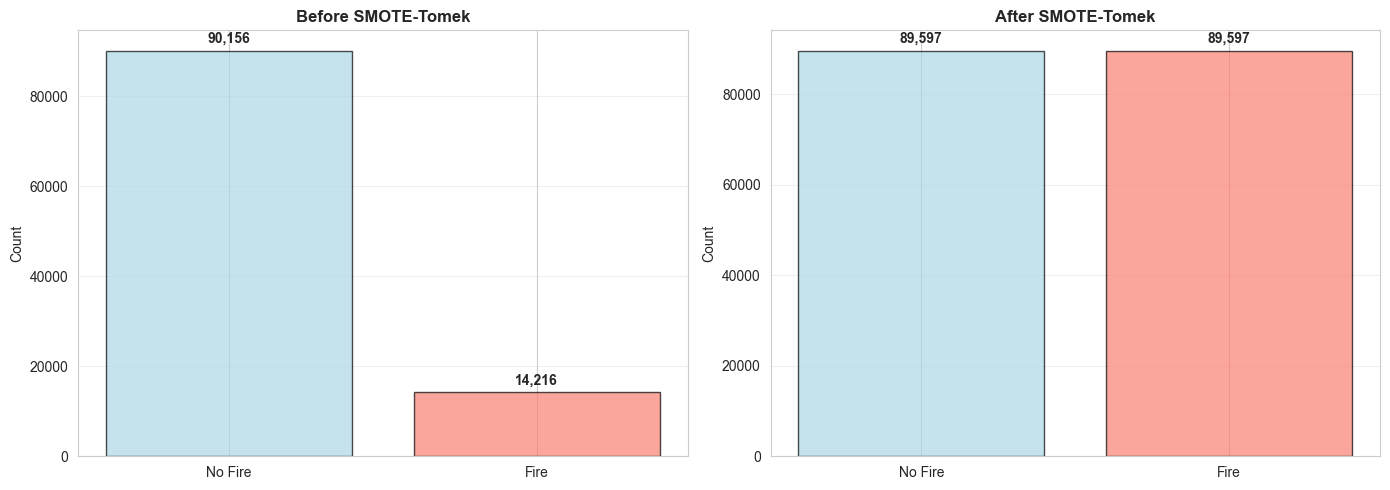


 Training samples: 104,372 → 179,194
 Geographic coordinates found
Features for clustering: 16
Samples: 104,372

 Scaling features...
Scaled range: [0.0000, 1.0000]

 Data preparation complete


In [4]:

# ## 1. Load and Prepare Data

def load_and_prepare_data(filepath):
    """
    Load data and prepare for clustering.
    
    Parameters:
    -----------
    filepath : str
        Path to cleaned dataset
    
    Returns:
    --------
    X_scaled : array
        Scaled features
    df : DataFrame
        Original dataframe
    scaler : MinMaxScaler
        Fitted scaler
    coords : array or None
        Geographic coordinates if available
    """
    
    print("="*70)
    print("DATA PREPARATION FOR CLUSTERING")
    print("="*70)
    
    # Load data
    df = pd.read_csv(filepath)
    print(f" Dataset loaded: {df.shape}")

    # Class balancing
    X, y = df.drop(columns=['fire']), df['fire'].values
    X, y = apply_smote_tomek(X, y)
    
    # Check for geographic columns
    coords = None
    if 'latitude' in df.columns and 'longitude' in df.columns:
        coords = df[['latitude', 'longitude']].values
        print(f" Geographic coordinates found")
        X = df.drop(columns=['latitude', 'longitude']).values
    
    
    print(f"Features for clustering: {X.shape[1]}")
    print(f"Samples: {len(X):,}")

    
    # Feature scaling
    print("\n Scaling features...")
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"Scaled range: [{X_scaled.min():.4f}, {X_scaled.max():.4f}]")
    
    print("\n Data preparation complete")
    print("="*70)
    
    return X_scaled, df, scaler, coords

# Load and prepare data
X_scaled, df, scaler, coords = load_and_prepare_data(
    "../data/processed/Fire/final.csv"
)


## 2. K-Means Clustering (From Scratch)

In [5]:

print("\n" + "="*70)
print("MODEL 1: K-MEANS (FROM SCRATCH)")
print("="*70)

## 2.1 K-Means Implementation

class KMeans:
    """
    K-Means clustering implemented from scratch.
    
    Optimizations:
    - Vectorized distance computation
    - Early convergence check
    - Empty cluster handling
    """
    
    def __init__(self, k=3, max_iters=300, tol=1e-4):
        """
        Initialize K-Means.
        
        Parameters:
        -----------
        k : int
            Number of clusters
        max_iters : int
            Maximum iterations
        tol : float
            Convergence tolerance
        """
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.clusters = None
        self.inertia_ = None
    
    def _euclidean_distance(self, a, b):
        """Compute Euclidean distance (vectorized)."""
        return np.sqrt(np.sum((a - b) ** 2, axis=1))
    
    def _create_clusters(self, X):
        """Assign samples to nearest centroid."""
        clusters = [[] for _ in range(self.k)]
        
        for idx, sample in enumerate(X):
            # Vectorized distance computation
            distances = self._euclidean_distance(self.centroids, sample.reshape(1, -1))
            centroid_idx = np.argmin(distances)
            clusters[centroid_idx].append(idx)
        
        return clusters
    
    def _calculate_centroids(self, X):
        """Calculate new centroids."""
        centroids = np.zeros((self.k, X.shape[1]))
        
        for idx, cluster in enumerate(self.clusters):
            if cluster:
                centroids[idx] = np.mean(X[cluster], axis=0)
            else:
                # Handle empty cluster by reinitializing
                centroids[idx] = X[np.random.choice(len(X))]
        
        return centroids
    
    def _compute_inertia(self, X):
        """Compute inertia (sum of squared distances)."""
        inertia = 0
        for i, cluster in enumerate(self.clusters):
            for idx in cluster:
                dist = np.linalg.norm(X[idx] - self.centroids[i])
                inertia += dist ** 2
        return inertia
    
    def fit(self, X):
        """
        Train K-Means on data.
        
        Parameters:
        -----------
        X : array
            Training data
        
        Returns:
        --------
        self
        """
        n_samples = X.shape[0]
        
        # Initialize centroids randomly
        random_idx = np.random.choice(n_samples, self.k, replace=False)
        self.centroids = X[random_idx]
        
        for iteration in range(self.max_iters):
            # Assign clusters
            self.clusters = self._create_clusters(X)
            
            # Store old centroids
            centroids_old = self.centroids.copy()
            
            # Update centroids
            self.centroids = self._calculate_centroids(X)
            
            # Check convergence
            diff = np.linalg.norm(self.centroids - centroids_old)
            if diff < self.tol:
                print(f"  Converged at iteration {iteration + 1}")
                break
        
        # Compute inertia
        self.inertia_ = self._compute_inertia(X)
        
        return self
    
    def predict(self, X):
        """
        Predict cluster labels.
        
        Parameters:
        -----------
        X : array
            Data to predict
        
        Returns:
        --------
        labels : array
            Cluster labels
        """
        labels = np.zeros(len(X), dtype=int)
        
        for idx, sample in enumerate(X):
            distances = self._euclidean_distance(self.centroids, sample.reshape(1, -1))
            labels[idx] = np.argmin(distances)
        
        return labels



MODEL 1: K-MEANS (FROM SCRATCH)


In [ ]:
## 2.2 Train and Evaluate K-Means

def train_and_evaluate_kmeans(X_scaled, k=5):
    """
    Train and evaluate K-Means from scratch.
    
    Parameters:
    -----------
    X_scaled : array
        Scaled features
    k : int
        Number of clusters
    
    Returns:
    --------
    kmeans : KMeans
        Trained model
    labels : array
        Cluster labels
    metrics : dict
        Evaluation metrics
    """
    
    print(f"\n Training K-Means from scratch (k={k})...")
    
    start_time = time()
    kmeans = KMeans(k=k, max_iters=300, tol=1e-4)
    kmeans.fit(X_scaled)
    train_time = time() - start_time
    
    labels = kmeans.predict(X_scaled)
    
    print(f" Training complete in {train_time:.2f} seconds")
    print(f"   Inertia: {kmeans.inertia_:.2f}")
    
    # Cluster distribution
    print(f"\n Cluster Distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for cluster_id, count in zip(unique, counts):
        print(f"   Cluster {cluster_id}: {count:,} ({count/len(labels)*100:.1f}%)")
    
    # Calculate metrics
    print(f"\n Evaluation Metrics:")
    
    silhouette = silhouette_score(X_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_scaled, labels)
    calinski = calinski_harabasz_score(X_scaled, labels)
    
    print(f"   Silhouette Score: {silhouette:.4f}")
    print(f"   Davies-Bouldin Index: {davies_bouldin:.4f} ⭐")
    print(f"   Calinski-Harabasz Score: {calinski:.2f}")
    
    metrics = {
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski,
        'inertia': kmeans.inertia_,
        'train_time': train_time,
        'n_clusters': k
    }
    
    return kmeans, labels, metrics

# Train K-Means with optimal k
kmeans_model, kmeans_labels, kmeans_metrics = train_and_evaluate_kmeans(X_scaled, k=3)



 Training K-Means from scratch (k=3)...
  Converged at iteration 26
 Training complete in 25.58 seconds
   Inertia: 29404.16

 Cluster Distribution:
   Cluster 0: 33,608 (32.2%)
   Cluster 1: 56,578 (54.2%)
   Cluster 2: 14,186 (13.6%)

 Evaluation Metrics:
   Silhouette Score: 0.3351
   Davies-Bouldin Index: 1.3613 ⭐
   Calinski-Harabasz Score: 39431.17


## 3. DBSCAN (From Scratch - Optimized)

In [7]:


print("\n" + "="*70)
print("MODEL 2: DBSCAN (FROM SCRATCH - OPTIMIZED)")
print("="*70)

## 3.1 DBSCAN Implementation

class DBSCAN:
    """
    DBSCAN clustering implemented from scratch.
    
    Optimizations:
    - Vectorized distance computation
    - Set-based operations for neighbor finding
    - Early termination
    """
    
    def __init__(self, eps=0.1, min_pts=5):
        """
        Initialize DBSCAN.
        
        Parameters:
        -----------
        eps : float
            Maximum distance for neighborhood
        min_pts : int
            Minimum points for core point
        """
        self.eps = eps
        self.min_pts = min_pts
        self.labels_ = None
        self.n_clusters_ = 0
    
    def _region_query_vectorized(self, X, point_idx):
        """
        Find neighbors using vectorized operations.
        
        Parameters:
        -----------
        X : array
            Data
        point_idx : int
            Point index
        
        Returns:
        --------
        neighbors : array
            Neighbor indices
        """
        # Vectorized distance computation
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        neighbors = np.where(distances <= self.eps)[0]
        return neighbors
    
    def _expand_cluster(self, X, labels, point_idx, neighbors, cluster_id):
        """
        Expand cluster from seed point.
        
        Parameters:
        -----------
        X : array
            Data
        labels : array
            Current labels
        point_idx : int
            Seed point index
        neighbors : array
            Neighbor indices
        cluster_id : int
            Current cluster ID
        """
        labels[point_idx] = cluster_id
        
        # Use set for efficient membership testing
        neighbors_set = set(neighbors.tolist())
        processed = set()
        
        while neighbors_set:
            neighbor_idx = neighbors_set.pop()
            
            if neighbor_idx in processed:
                continue
            processed.add(neighbor_idx)
            
            # If noise, make it part of cluster
            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id
            
            # If unvisited
            if labels[neighbor_idx] == 0:
                labels[neighbor_idx] = cluster_id
                
                # Find new neighbors
                new_neighbors = self._region_query_vectorized(X, neighbor_idx)
                
                # If core point, add new neighbors
                if len(new_neighbors) >= self.min_pts:
                    neighbors_set.update(new_neighbors.tolist())
    
    def fit(self, X):
        """
        Train DBSCAN on data.
        
        Parameters:
        -----------
        X : array
            Training data
        
        Returns:
        --------
        self
        """
        n = len(X)
        labels = np.zeros(n, dtype=int)  # 0 = unvisited
        cluster_id = 0
        
        print(f"  Processing {n:,} points...")
        
        for i in range(n):
            if i % 10000 == 0 and i > 0:
                print(f"    Processed {i:,}/{n:,} points...")
            
            if labels[i] != 0:
                continue
            
            # Find neighbors
            neighbors = self._region_query_vectorized(X, i)
            
            # Not a core point → noise
            if len(neighbors) < self.min_pts:
                labels[i] = -1
            else:
                # Found new cluster
                cluster_id += 1
                self._expand_cluster(X, labels, i, neighbors, cluster_id)
        
        self.labels_ = labels
        self.n_clusters_ = cluster_id
        
        return self
    
    def predict(self, X):
        """Return stored labels (DBSCAN doesn't support new predictions)."""
        return self.labels_




MODEL 2: DBSCAN (FROM SCRATCH - OPTIMIZED)


In [8]:
## 3.2 Train and Evaluate DBSCAN

def train_and_evaluate_dbscan(X_scaled, eps=0.15, min_pts=100):
    """
    Train and evaluate DBSCAN from scratch.
    
    Parameters:
    -----------
    X_scaled : array
        Scaled features
    eps : float
        Epsilon parameter
    min_pts : int
        Minimum points parameter
    
    Returns:
    --------
    dbscan : DBSCAN
        Trained model
    labels : array
        Cluster labels
    metrics : dict
        Evaluation metrics
    """
    
    print(f"\n Training DBSCAN from scratch...")
    print(f"   eps={eps}, min_pts={min_pts}")
    
    start_time = time()
    dbscan = DBSCAN(eps=eps, min_pts=min_pts)
    dbscan.fit(X_scaled)
    train_time = time() - start_time
    
    labels = dbscan.labels_
    
    print(f"\n Training complete in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")
    
    # Statistics
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels != -1])
    n_noise = np.sum(labels == -1)
    noise_ratio = n_noise / len(labels) * 100
    
    print(f"\n Clustering Results:")
    print(f"   Clusters found: {n_clusters}")
    print(f"   Noise points: {n_noise:,} ({noise_ratio:.2f}%)")
    
    # Cluster sizes
    print(f"\n Cluster Distribution:")
    for cluster_id in unique_labels:
        if cluster_id == -1:
            continue
        count = np.sum(labels == cluster_id)
        print(f"   Cluster {cluster_id}: {count:,} ({count/len(labels)*100:.1f}%)")
    
    # Calculate metrics (exclude noise)
    print(f"\n Evaluation Metrics:")
    
    mask = labels != -1
    X_core = X_scaled[mask]
    labels_core = labels[mask]
    
    if len(np.unique(labels_core)) > 1:
        silhouette = silhouette_score(X_core, labels_core)
        davies_bouldin = davies_bouldin_score(X_core, labels_core)
        calinski = calinski_harabasz_score(X_core, labels_core)
        
        print(f"   Silhouette Score (no noise): {silhouette:.4f}")
        print(f"   Davies-Bouldin Index: {davies_bouldin:.4f} ⭐")
        print(f"   Calinski-Harabasz Score: {calinski:.2f}")
    else:
        silhouette = None
        davies_bouldin = None
        calinski = None
        print(f"   Metrics undefined (insufficient clusters)")
    
    metrics = {
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': noise_ratio,
        'train_time': train_time
    }
    
    return dbscan, labels, metrics

# Train DBSCAN with optimal parameters
dbscan_model, dbscan_labels, dbscan_metrics = train_and_evaluate_dbscan(
    X_scaled, eps=0.10, min_pts=10
)


 Training DBSCAN from scratch...
   eps=0.1, min_pts=10
  Processing 104,372 points...
    Processed 10,000/104,372 points...
    Processed 20,000/104,372 points...
    Processed 30,000/104,372 points...
    Processed 40,000/104,372 points...
    Processed 50,000/104,372 points...
    Processed 60,000/104,372 points...
    Processed 70,000/104,372 points...
    Processed 80,000/104,372 points...
    Processed 90,000/104,372 points...
    Processed 100,000/104,372 points...

 Training complete in 972.42 seconds (16.21 minutes)

 Clustering Results:
   Clusters found: 298
   Noise points: 4,345 (4.16%)

 Cluster Distribution:
   Cluster 1: 405 (0.4%)
   Cluster 2: 414 (0.4%)
   Cluster 3: 1,173 (1.1%)
   Cluster 4: 3,650 (3.5%)
   Cluster 5: 3,239 (3.1%)
   Cluster 6: 565 (0.5%)
   Cluster 7: 13 (0.0%)
   Cluster 8: 31 (0.0%)
   Cluster 9: 145 (0.1%)
   Cluster 10: 188 (0.2%)
   Cluster 11: 554 (0.5%)
   Cluster 12: 42 (0.0%)
   Cluster 13: 85 (0.1%)
   Cluster 14: 33 (0.0%)
   Cluster 

## 4. CLARANS (From Scratch)

In [9]:
print("\n" + "="*70)
print("MODEL 3: CLARANS (FROM SCRATCH)")
print("="*70)

## 4.1 CLARANS Implementation

class CLARANS:
    """
    CLARANS clustering implemented from scratch.
    
    Optimizations:
    - Efficient cost computation
    - Random neighbor search
    - Multiple local searches
    """
    
    def __init__(self, k=3, max_neighbors=100, num_local=5):
        """
        Initialize CLARANS.
        
        Parameters:
        -----------
        k : int
            Number of clusters
        max_neighbors : int
            Maximum neighbors to explore
        num_local : int
            Number of local searches
        """
        self.k = k
        self.max_neighbors = max_neighbors
        self.num_local = num_local
        self.medoids = None
        self.labels_ = None
        self.cost_ = None
    
    def _compute_cost(self, X, medoids):
        """
        Compute total cost (sum of distances to medoids).
        
        Parameters:
        -----------
        X : array
            Data
        medoids : list
            Medoid indices
        
        Returns:
        --------
        cost : float
            Total cost
        """
        cost = 0
        for i in range(len(X)):
            distances = [np.linalg.norm(X[i] - X[m]) for m in medoids]
            cost += min(distances)
        return cost
    
    def _assign_clusters(self, X, medoids):
        """
        Assign samples to nearest medoid.
        
        Parameters:
        -----------
        X : array
            Data
        medoids : list
            Medoid indices
        
        Returns:
        --------
        labels : array
            Cluster labels
        """
        labels = np.zeros(len(X), dtype=int)
        
        for i in range(len(X)):
            distances = [np.linalg.norm(X[i] - X[m]) for m in medoids]
            labels[i] = np.argmin(distances)
        
        return labels
    
    def fit(self, X):
        """
        Train CLARANS on data.
        
        Parameters:
        -----------
        X : array
            Training data
        
        Returns:
        --------
        self
        """
        n = len(X)
        best_medoids = None
        best_cost = np.inf
        
        print(f"  Performing {self.num_local} local searches...")
        
        # Multiple local searches
        for L in range(self.num_local):
            print(f"    Local search {L+1}/{self.num_local}...", end=' ')
            
            # Initialize medoids randomly
            medoids = list(np.random.choice(n, self.k, replace=False))
            current_cost = self._compute_cost(X, medoids)
            
            neighbors_explored = 0
            
            # Explore random neighbors
            while neighbors_explored < self.max_neighbors:
                # Pick random medoid and non-medoid
                m_i = np.random.choice(medoids)
                non_medoids = [x for x in range(n) if x not in medoids]
                h = np.random.choice(non_medoids)
                
                # Create new medoid set
                new_medoids = medoids.copy()
                new_medoids[new_medoids.index(m_i)] = h
                
                new_cost = self._compute_cost(X, new_medoids)
                
                if new_cost < current_cost:
                    medoids = new_medoids
                    current_cost = new_cost
                    neighbors_explored = 0  # Restart search
                else:
                    neighbors_explored += 1
            
            print(f"Cost: {current_cost:.2f}")
            
            # Keep best solution
            if current_cost < best_cost:
                best_cost = current_cost
                best_medoids = medoids
        
        self.medoids = best_medoids
        self.labels_ = self._assign_clusters(X, best_medoids)
        self.cost_ = best_cost
        
        return self


MODEL 3: CLARANS (FROM SCRATCH)


In [10]:
## 4.2 Train and Evaluate CLARANS

def train_and_evaluate_clarans(X_scaled, k=4, max_neighbors=100, num_local=5):
    """
    Train and evaluate CLARANS from scratch.
    
    Parameters:
    -----------
    X_scaled : array
        Scaled features
    k : int
        Number of clusters
    max_neighbors : int
        Maximum neighbors
    num_local : int
        Number of local searches
    
    Returns:
    --------
    clarans : CLARANS
        Trained model
    labels : array
        Cluster labels
    metrics : dict
        Evaluation metrics
    """
    
    print(f"\n Training CLARANS from scratch...")
    print(f"   k={k}, max_neighbors={max_neighbors}, num_local={num_local}")
    
    start_time = time()
    clarans = CLARANS(k=k, max_neighbors=max_neighbors, num_local=num_local)
    clarans.fit(X_scaled)
    train_time = time() - start_time
    
    labels = clarans.labels_
    
    print(f"\n Training complete in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")
    print(f"   Final cost: {clarans.cost_:.2f}")
    print(f"   Medoids: {clarans.medoids}")
    
    # Cluster distribution
    print(f"\n Cluster Distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for cluster_id, count in zip(unique, counts):
        print(f"   Cluster {cluster_id}: {count:,} ({count/len(labels)*100:.1f}%)")
    
    # Calculate metrics
    print(f"\n Evaluation Metrics:")
    
    silhouette = silhouette_score(X_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_scaled, labels)
    calinski = calinski_harabasz_score(X_scaled, labels)
    
    print(f"   Silhouette Score: {silhouette:.4f}")
    print(f"   Davies-Bouldin Index: {davies_bouldin:.4f} ⭐")
    print(f"   Calinski-Harabasz Score: {calinski:.2f}")
    
    metrics = {
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski,
        'cost': clarans.cost_,
        'train_time': train_time,
        'n_clusters': k
    }
    
    return clarans, labels, metrics

# Train CLARANS with optimal parameters
clarans_model, clarans_labels, clarans_metrics = train_and_evaluate_clarans(
    X_scaled, k=3, max_neighbors=100, num_local=5
)



 Training CLARANS from scratch...
   k=3, max_neighbors=100, num_local=5
  Performing 5 local searches...
    Local search 1/5... Cost: 49919.18
    Local search 2/5... Cost: 51791.34
    Local search 3/5... Cost: 49849.36
    Local search 4/5... Cost: 49250.48
    Local search 5/5... Cost: 50181.43

 Training complete in 1688.58 seconds (28.14 minutes)
   Final cost: 49250.48
   Medoids: [85306, 70182, 10191]

 Cluster Distribution:
   Cluster 0: 65,690 (62.9%)
   Cluster 1: 24,466 (23.4%)
   Cluster 2: 14,216 (13.6%)

 Evaluation Metrics:
   Silhouette Score: 0.3222
   Davies-Bouldin Index: 1.0592 ⭐
   Calinski-Harabasz Score: 38700.42


## 5. Visualization


PCA VISUALIZATION
PCA explained variance: [0.37349179 0.24282306]
Total variance: 61.63%


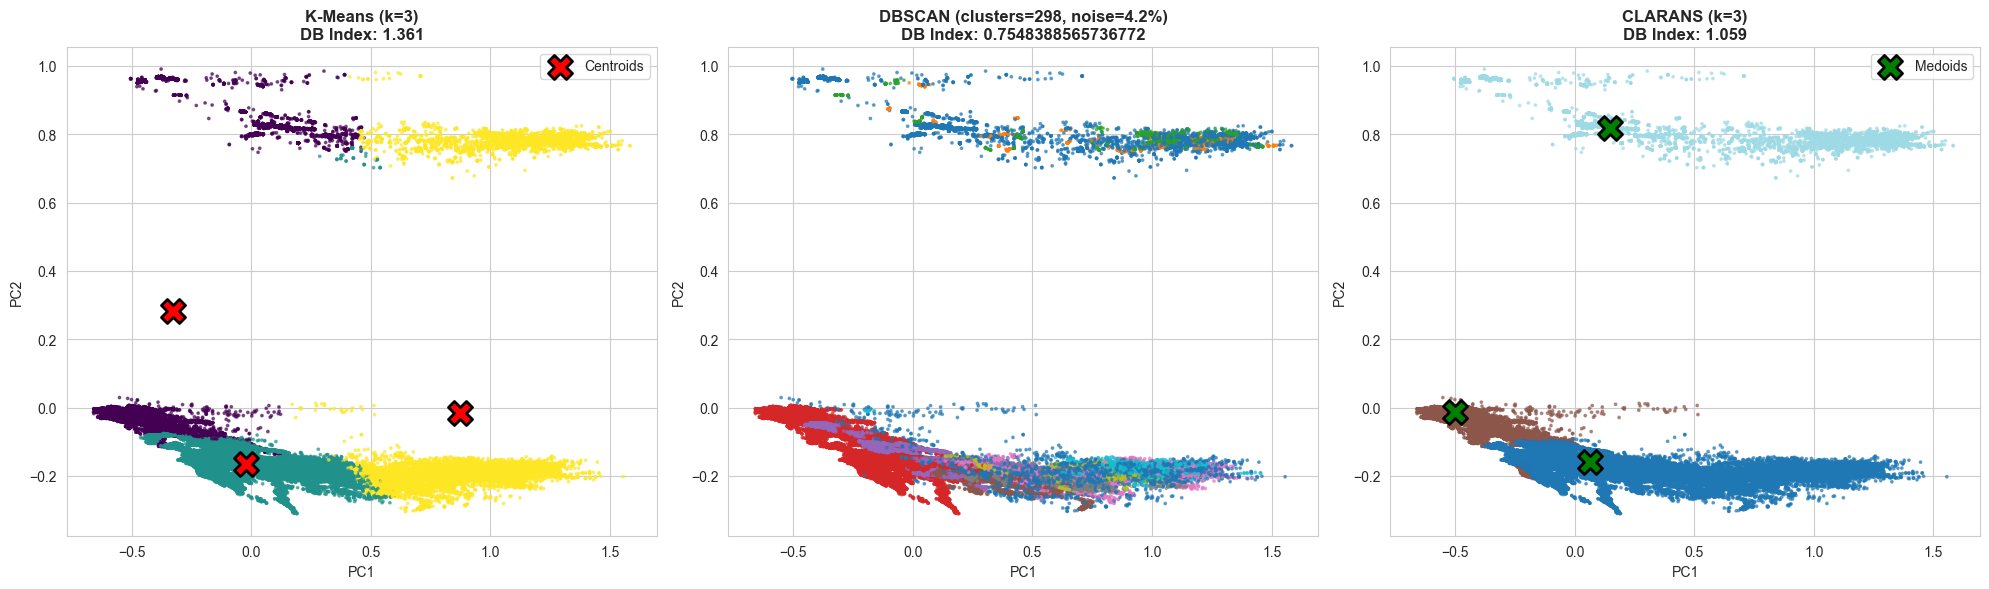

PCA visualization saved


In [11]:
## 5.1 PCA Visualization

def visualize_clusters_pca(X_scaled, labels_dict, models_dict):
    """
    Visualize clusters in PCA space.
    
    Parameters:
    -----------
    X_scaled : array
        Scaled features
    labels_dict : dict
        Dictionary of labels
    models_dict : dict
        Dictionary of models
    """
    
    print("\n" + "="*70)
    print("PCA VISUALIZATION")
    print("="*70)
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"PCA explained variance: {pca.explained_variance_ratio_}")
    print(f"Total variance: {sum(pca.explained_variance_ratio_):.2%}")
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # K-Means
    scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                             c=labels_dict['kmeans'], cmap='viridis', s=3, alpha=0.6)
    # Plot centroids
    centroids_pca = pca.transform(models_dict['kmeans'].centroids)
    axes[0].scatter(centroids_pca[:, 0], centroids_pca[:, 1],
                   c='red', s=300, marker='X', edgecolors='black', linewidths=2, label='Centroids')
    axes[0].set_title(f'K-Means (k={kmeans_metrics["n_clusters"]})\nDB Index: {kmeans_metrics["davies_bouldin"]:.3f}',
                     fontsize=12, fontweight='bold')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    axes[0].legend()
    
    # DBSCAN
    scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1],
                             c=labels_dict['dbscan'], cmap='tab10', s=3, alpha=0.6)
    axes[1].set_title(f'DBSCAN (clusters={dbscan_metrics["n_clusters"]}, noise={dbscan_metrics["noise_ratio"]:.1f}%)\nDB Index: {dbscan_metrics.get("davies_bouldin", "N/A")}',
                     fontsize=12, fontweight='bold')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')
    
    # CLARANS
    scatter = axes[2].scatter(X_pca[:, 0], X_pca[:, 1],
                             c=labels_dict['clarans'], cmap='tab20', s=3, alpha=0.6)
    # Plot medoids
    medoids_pca = X_pca[models_dict['clarans'].medoids]
    axes[2].scatter(medoids_pca[:, 0], medoids_pca[:, 1],
                   c='green', s=300, marker='X', edgecolors='black', linewidths=2, label='Medoids')
    axes[2].set_title(f'CLARANS (k={clarans_metrics["n_clusters"]})\nDB Index: {clarans_metrics["davies_bouldin"]:.3f}',
                     fontsize=12, fontweight='bold')
    axes[2].set_xlabel('PC1')
    axes[2].set_ylabel('PC2')
    axes[2].legend()
    
    plt.tight_layout()
    plt.savefig('../outputs/clustering_from_scratch_pca.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("PCA visualization saved")
    print("="*70)

# Visualize
labels_dict = {
    'kmeans': kmeans_labels,
    'dbscan': dbscan_labels,
    'clarans': clarans_labels
}

models_dict = {
    'kmeans': kmeans_model,
    'dbscan': dbscan_model,
    'clarans': clarans_model
}

visualize_clusters_pca(X_scaled, labels_dict, models_dict)



GEOGRAPHIC VISUALIZATION


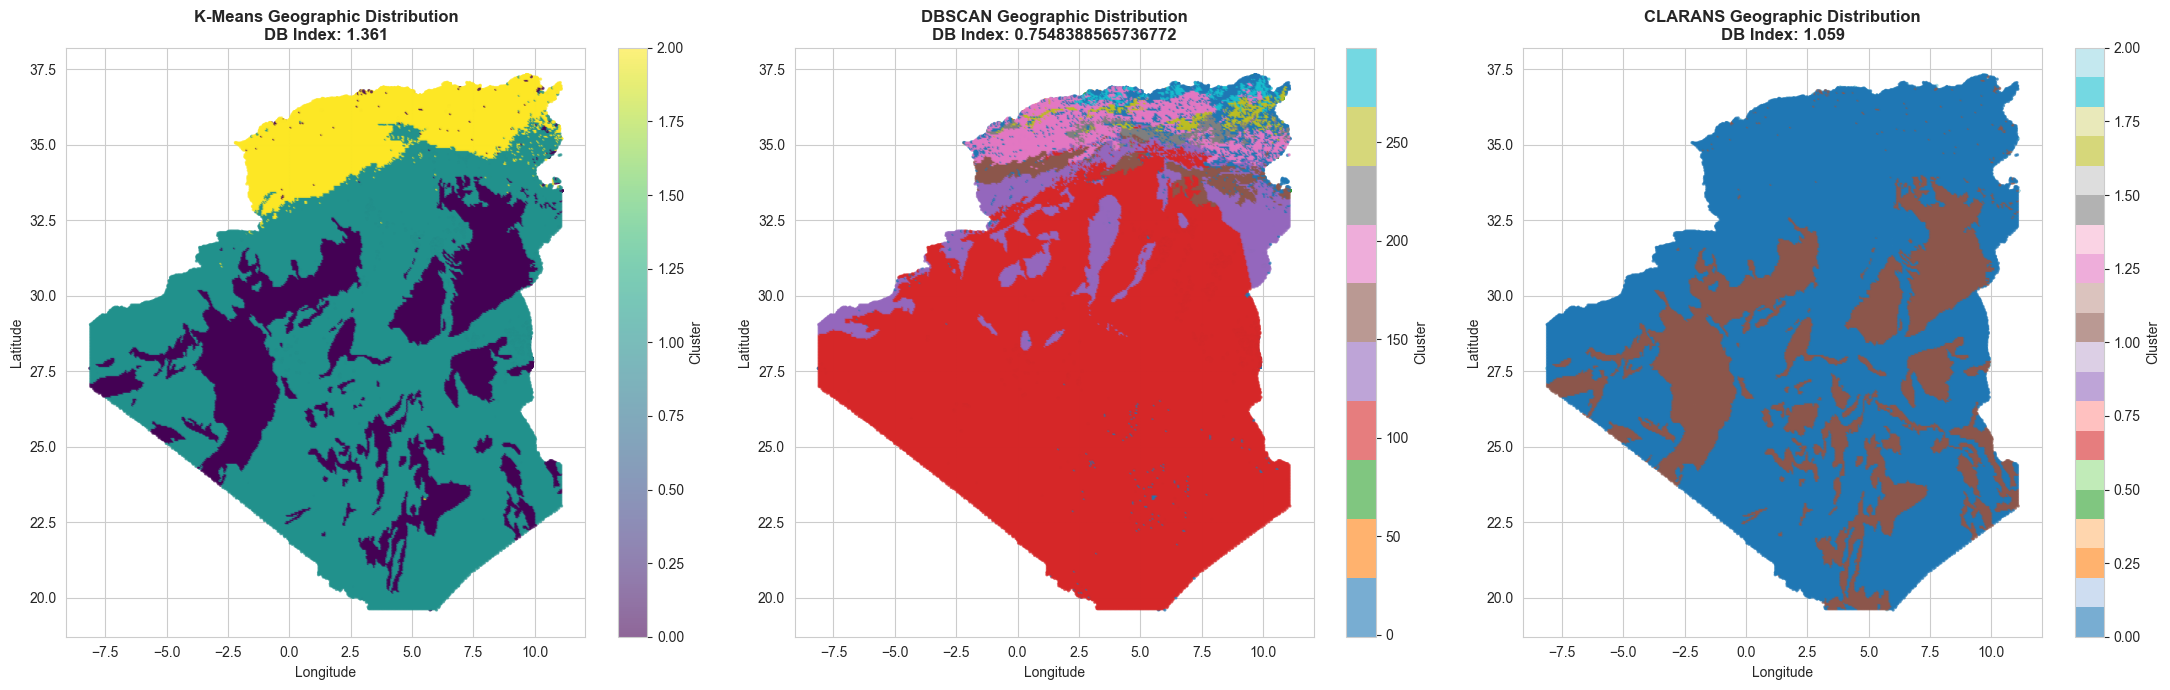

 Geographic visualization saved


In [12]:
## 5.2 Geographic Visualization

def visualize_clusters_geographic(coords, labels_dict, metrics_dict):
    """
    Visualize clusters on geographic map.
    
    Parameters:
    -----------
    coords : array
        Geographic coordinates
    labels_dict : dict
        Dictionary of labels
    metrics_dict : dict
        Dictionary of metrics
    """
    
    if coords is None:
        print("⚠️  No geographic coordinates available")
        return
    
    print("\n" + "="*70)
    print("GEOGRAPHIC VISUALIZATION")
    print("="*70)
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 7))
    
    # K-Means
    scatter = axes[0].scatter(coords[:, 1], coords[:, 0],
                             c=labels_dict['kmeans'], cmap='viridis', s=2, alpha=0.6)
    axes[0].set_title(f'K-Means Geographic Distribution\nDB Index: {metrics_dict["kmeans"]["davies_bouldin"]:.3f}',
                     fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    plt.colorbar(scatter, ax=axes[0], label='Cluster')
    
    # DBSCAN
    scatter = axes[1].scatter(coords[:, 1], coords[:, 0],
                             c=labels_dict['dbscan'], cmap='tab10', s=2, alpha=0.6)
    db_idx = metrics_dict["dbscan"].get("davies_bouldin", "N/A")
    axes[1].set_title(f'DBSCAN Geographic Distribution\nDB Index: {db_idx}',
                     fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    plt.colorbar(scatter, ax=axes[1], label='Cluster')
    
    # CLARANS
    scatter = axes[2].scatter(coords[:, 1], coords[:, 0],
                             c=labels_dict['clarans'], cmap='tab20', s=2, alpha=0.6)
    axes[2].set_title(f'CLARANS Geographic Distribution\nDB Index: {metrics_dict["clarans"]["davies_bouldin"]:.3f}',
                     fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Longitude')
    axes[2].set_ylabel('Latitude')
    plt.colorbar(scatter, ax=axes[2], label='Cluster')
    
    plt.tight_layout()
    plt.savefig('../outputs/clustering_from_scratch_geographic.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(" Geographic visualization saved")
    print("="*70)

# Visualize geographically
metrics_dict = {
    'kmeans': kmeans_metrics,
    'dbscan': dbscan_metrics,
    'clarans': clarans_metrics
}

visualize_clusters_geographic(coords, labels_dict, metrics_dict)


## 6. Fire Risk Analysis

In [13]:
def analyze_fire_risk_by_cluster(df, labels_dict):
    """
    Analyze fire occurrence patterns within each cluster.
    
    Parameters:
    -----------
    df : DataFrame
        Original dataframe
    labels_dict : dict
        Dictionary of labels
    
    Returns:
    --------
    risk_results : dict
        Fire risk analysis for all methods
    """
    
    print("\n" + "="*70)
    print("FIRE RISK ANALYSIS BY CLUSTER")
    print("="*70)
    
    risk_results = {}
    
    for method_name, labels in labels_dict.items():
        print(f"\n🔥 {method_name.upper()} - Fire Risk Analysis:")
        print("-" * 50)
        
        unique_labels = sorted([l for l in np.unique(labels) if l != -1])
        
        risk_data = []
        for cluster_id in unique_labels:
            cluster_mask = labels == cluster_id
            cluster_size = cluster_mask.sum()
            fire_count = df.loc[cluster_mask, 'fire'].sum()
            fire_rate = (fire_count / cluster_size * 100) if cluster_size > 0 else 0
            
            risk_level = 'High' if fire_rate > 10 else 'Medium' if fire_rate > 5 else 'Low'
            
            risk_data.append({
                'cluster': cluster_id,
                'size': cluster_size,
                'fire_count': int(fire_count),
                'fire_rate': fire_rate,
                'risk_level': risk_level
            })
            
            print(f"  Cluster {cluster_id}: Size={cluster_size:,}, "
                  f"Fires={int(fire_count):,}, Rate={fire_rate:.2f}%, Risk={risk_level}")
        
        # Handle noise for DBSCAN
        if method_name == 'dbscan' and -1 in labels:
            noise_mask = labels == -1
            noise_size = noise_mask.sum()
            noise_fires = df.loc[noise_mask, 'fire'].sum()
            noise_rate = (noise_fires / noise_size * 100) if noise_size > 0 else 0
            
            print(f"  Noise: Size={noise_size:,}, "
                  f"Fires={int(noise_fires):,}, Rate={noise_rate:.2f}%")
        
        risk_results[method_name] = pd.DataFrame(risk_data)
    
    print("\n" + "="*70)
    
    return risk_results

# Analyze fire risk
fire_risk_results = analyze_fire_risk_by_cluster(df, labels_dict)



FIRE RISK ANALYSIS BY CLUSTER

🔥 KMEANS - Fire Risk Analysis:
--------------------------------------------------
  Cluster 0: Size=33,608, Fires=11,481, Rate=34.16%, Risk=High
  Cluster 1: Size=56,578, Fires=63, Rate=0.11%, Risk=Low
  Cluster 2: Size=14,186, Fires=2,672, Rate=18.84%, Risk=High

🔥 DBSCAN - Fire Risk Analysis:
--------------------------------------------------
  Cluster 1: Size=405, Fires=405, Rate=100.00%, Risk=High
  Cluster 2: Size=414, Fires=414, Rate=100.00%, Risk=High
  Cluster 3: Size=1,173, Fires=1,173, Rate=100.00%, Risk=High
  Cluster 4: Size=3,650, Fires=3,650, Rate=100.00%, Risk=High
  Cluster 5: Size=3,239, Fires=3,239, Rate=100.00%, Risk=High
  Cluster 6: Size=565, Fires=565, Rate=100.00%, Risk=High
  Cluster 7: Size=13, Fires=13, Rate=100.00%, Risk=High
  Cluster 8: Size=31, Fires=31, Rate=100.00%, Risk=High
  Cluster 9: Size=145, Fires=145, Rate=100.00%, Risk=High
  Cluster 10: Size=188, Fires=188, Rate=100.00%, Risk=High
  Cluster 11: Size=554, Fires=55

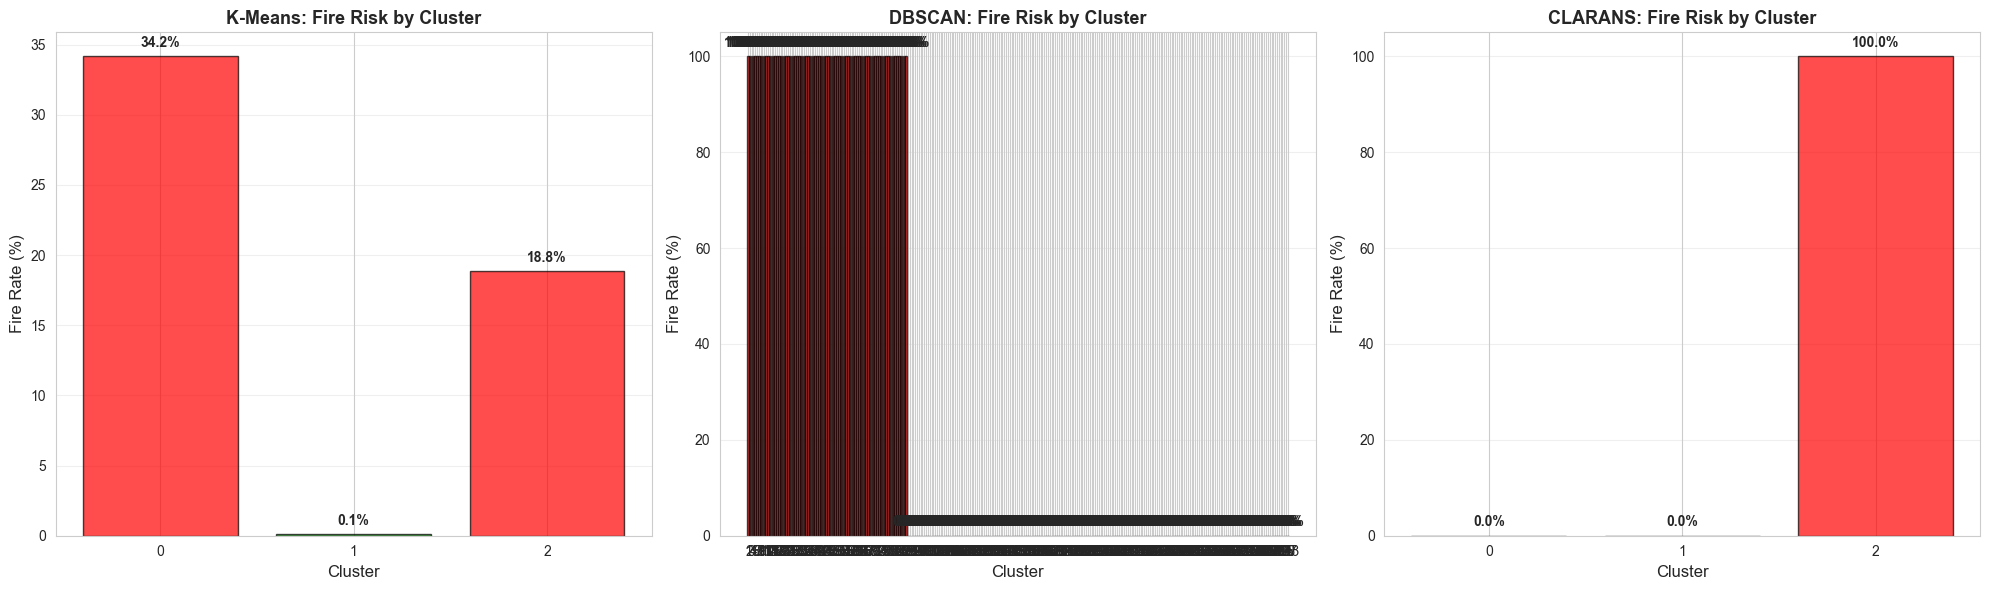

 Fire risk visualization saved


In [14]:
## 6.1 Visualize Fire Risk

def visualize_fire_risk(fire_risk_results):
    """
    Visualize fire risk for all clustering methods.
    
    Parameters:
    -----------
    fire_risk_results : dict
        Fire risk results
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    methods = ['kmeans', 'dbscan', 'clarans']
    titles = ['K-Means', 'DBSCAN', 'CLARANS']
    
    for ax, method, title in zip(axes, methods, titles):
        if method not in fire_risk_results:
            continue
        
        data = fire_risk_results[method]
        
        colors = ['red' if r > 10 else 'orange' if r > 5 else 'green' 
                 for r in data['fire_rate']]
        
        bars = ax.bar(data['cluster'].astype(str), data['fire_rate'],
                     color=colors, alpha=0.7, edgecolor='black')
        
        ax.set_xlabel('Cluster', fontsize=12)
        ax.set_ylabel('Fire Rate (%)', fontsize=12)
        ax.set_title(f'{title}: Fire Risk by Cluster', fontsize=13, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, (cluster, rate) in enumerate(zip(data['cluster'], data['fire_rate'])):
            ax.text(i, rate + max(data['fire_rate'])*0.02,
                   f'{rate:.1f}%', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../outputs/clustering_fire_risk.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(" Fire risk visualization saved")

visualize_fire_risk(fire_risk_results)


## 7. Model Comparison


CLUSTERING MODELS COMPARISON

 Performance Comparison:
 Method  N Clusters  Silhouette  Davies-Bouldin  Calinski-Harabasz  Train Time (s)
 KMEANS           3    0.335138        1.361264       39431.168757       25.584114
 DBSCAN         298    0.217345        0.754839        3527.911008      972.424025
CLARANS           3    0.322241        1.059208       38700.417575     1688.575181


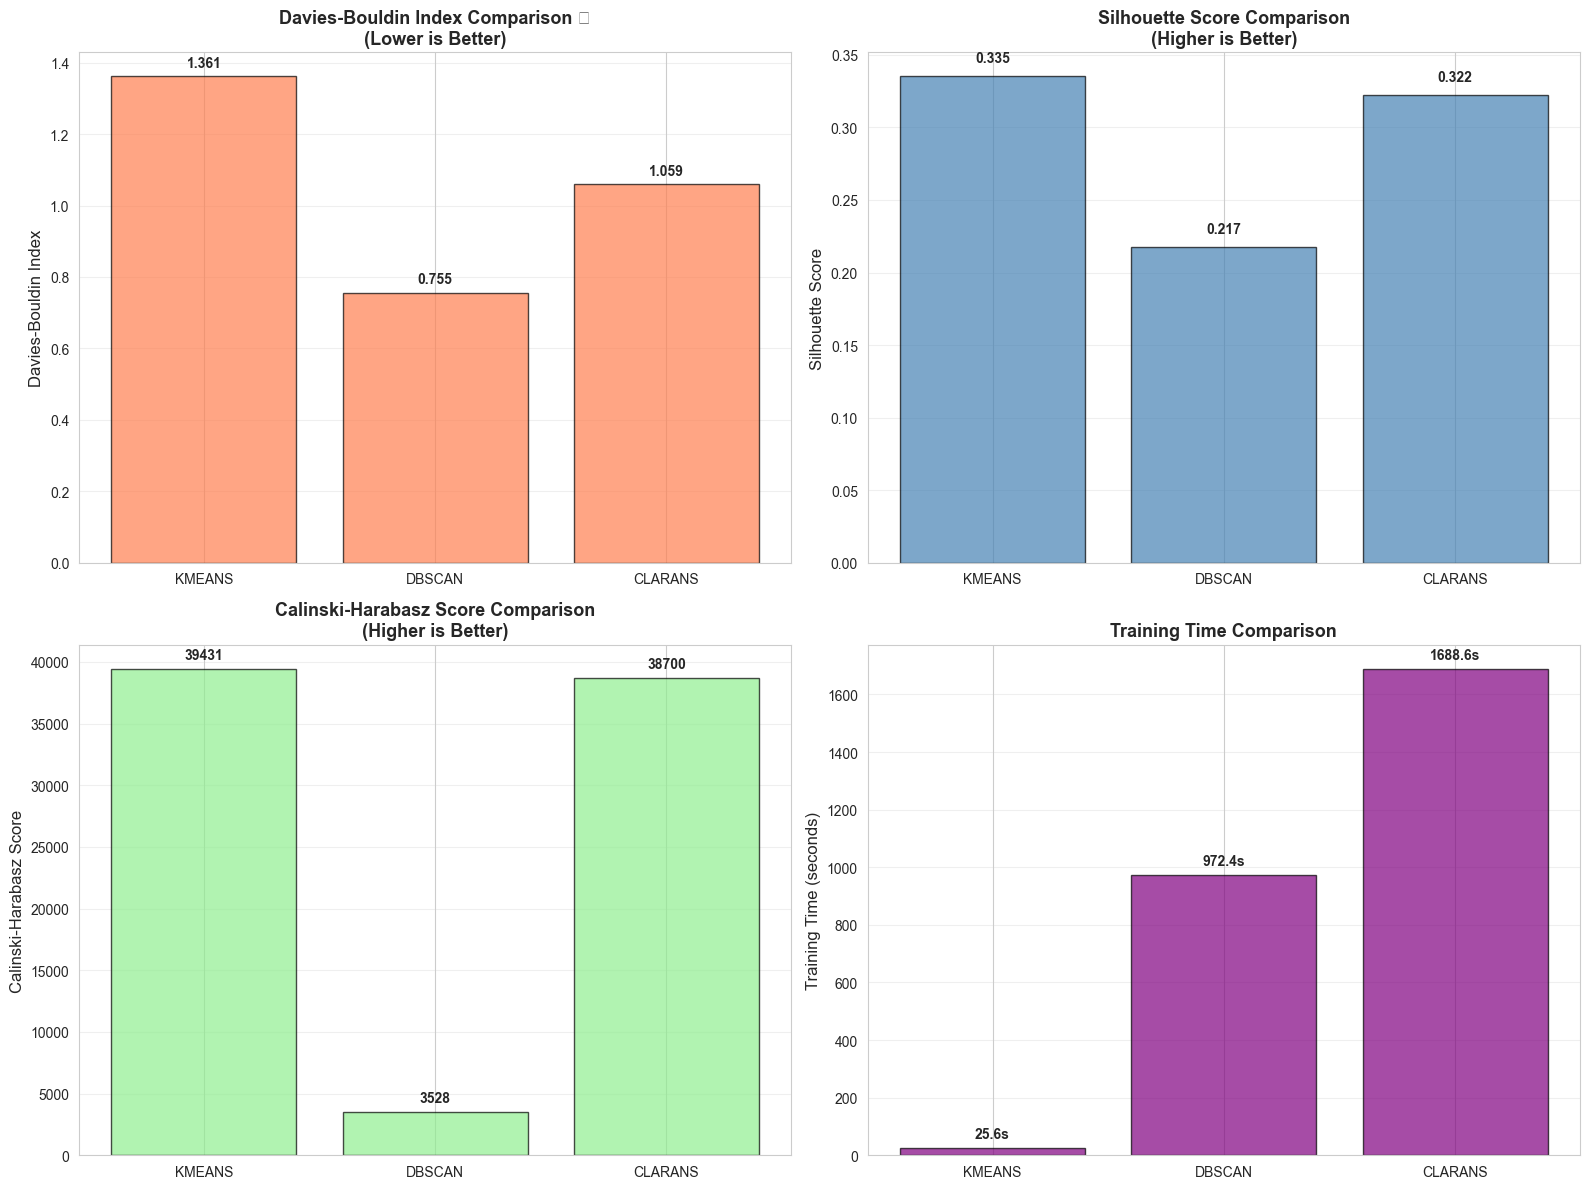


* Best Model (by Davies-Bouldin Index): DBSCAN
   Davies-Bouldin: 0.7548

 Comparison complete


In [15]:
def compare_clustering_models(metrics_dict):
    """
    Compare all clustering models.
    
    Parameters:
    -----------
    metrics_dict : dict
        Dictionary of metrics
    
    Returns:
    --------
    comparison_df : DataFrame
        Comparison results
    """
    
    print("\n" + "="*70)
    print("CLUSTERING MODELS COMPARISON")
    print("="*70)
    
    # Create comparison dataframe
    comparison_data = []
    
    for method, metrics in metrics_dict.items():
        comparison_data.append({
            'Method': method.upper(),
            'N Clusters': metrics.get('n_clusters', 0),
            'Silhouette': metrics.get('silhouette', np.nan),
            'Davies-Bouldin': metrics.get('davies_bouldin', np.nan),
            'Calinski-Harabasz': metrics.get('calinski_harabasz', np.nan),
            'Train Time (s)': metrics.get('train_time', 0)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n Performance Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    methods = comparison_df['Method'].values
    
    # Plot 1: Davies-Bouldin Index (Lower is better)
    valid_db = ~comparison_df['Davies-Bouldin'].isna()
    if valid_db.any():
        axes[0, 0].bar(methods[valid_db], comparison_df['Davies-Bouldin'][valid_db],
                      color='coral', alpha=0.7, edgecolor='black')
        axes[0, 0].set_ylabel('Davies-Bouldin Index', fontsize=12)
        axes[0, 0].set_title('Davies-Bouldin Index Comparison ⭐\n(Lower is Better)',
                            fontsize=13, fontweight='bold')
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        for i, (method, val) in enumerate(zip(methods[valid_db], 
                                              comparison_df['Davies-Bouldin'][valid_db])):
            axes[0, 0].text(i, val + max(comparison_df['Davies-Bouldin'][valid_db])*0.02,
                           f'{val:.3f}', ha='center', fontweight='bold')
    
    # Plot 2: Silhouette Score (Higher is better)
    valid_sil = ~comparison_df['Silhouette'].isna()
    if valid_sil.any():
        axes[0, 1].bar(methods[valid_sil], comparison_df['Silhouette'][valid_sil],
                      color='steelblue', alpha=0.7, edgecolor='black')
        axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
        axes[0, 1].set_title('Silhouette Score Comparison\n(Higher is Better)',
                            fontsize=13, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
        
        for i, (method, val) in enumerate(zip(methods[valid_sil],
                                              comparison_df['Silhouette'][valid_sil])):
            axes[0, 1].text(i, val + 0.01, f'{val:.3f}', ha='center', fontweight='bold')
    
    # Plot 3: Calinski-Harabasz Score (Higher is better)
    valid_ch = ~comparison_df['Calinski-Harabasz'].isna()
    if valid_ch.any():
        axes[1, 0].bar(methods[valid_ch], comparison_df['Calinski-Harabasz'][valid_ch],
                      color='lightgreen', alpha=0.7, edgecolor='black')
        axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=12)
        axes[1, 0].set_title('Calinski-Harabasz Score Comparison\n(Higher is Better)',
                            fontsize=13, fontweight='bold')
        axes[1, 0].grid(axis='y', alpha=0.3)
        
        for i, (method, val) in enumerate(zip(methods[valid_ch],
                                              comparison_df['Calinski-Harabasz'][valid_ch])):
            axes[1, 0].text(i, val + max(comparison_df['Calinski-Harabasz'][valid_ch])*0.02,
                           f'{val:.0f}', ha='center', fontweight='bold')
    
    # Plot 4: Training Time
    axes[1, 1].bar(methods, comparison_df['Train Time (s)'],
                   color='purple', alpha=0.7, edgecolor='black')
    axes[1, 1].set_ylabel('Training Time (seconds)', fontsize=12)
    axes[1, 1].set_title('Training Time Comparison', fontsize=13, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    for i, (method, time) in enumerate(zip(methods, comparison_df['Train Time (s)'])):
        axes[1, 1].text(i, time + max(comparison_df['Train Time (s)'])*0.02,
                       f'{time:.1f}s', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../outputs/clustering_comparison_from_scratch.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Best model by Davies-Bouldin (lower is better)
    valid_db_idx = comparison_df['Davies-Bouldin'].notna()
    if valid_db_idx.any():
        best_idx = comparison_df[valid_db_idx]['Davies-Bouldin'].idxmin()
        best_model = comparison_df.loc[best_idx, 'Method']
        best_db = comparison_df.loc[best_idx, 'Davies-Bouldin']
        
        print(f"\n* Best Model (by Davies-Bouldin Index): {best_model}")
        print(f"   Davies-Bouldin: {best_db:.4f}")
    
    print("\n Comparison complete")
    print("="*70)
    
    return comparison_df

# Compare all models
comparison_results = compare_clustering_models(metrics_dict)


## 8. Comparison with Scikit-Learn


COMPARISON WITH SCIKIT-LEARN

 K-Means (Scikit-learn)...
   Davies-Bouldin: 1.0084

 DBSCAN (Scikit-learn)...
   Davies-Bouldin: 0.7548

 K-Medoids (Scikit-learn)...
   Davies-Bouldin: 1.0360

 Comparison Results:
                 Model  Silhouette  Davies-Bouldin  Train Time
     K-Means (Sklearn)    0.445593        1.008420    0.268600
      DBSCAN (Sklearn)    0.217345        0.754839   36.038639
   K-Medoids (Sklearn)    0.330146        1.036022   21.270342
K-Means (From Scratch)    0.335138        1.361264   25.584114
 DBSCAN (From Scratch)    0.217345        0.754839  972.424025
CLARANS (From Scratch)    0.322241        1.059208 1688.575181


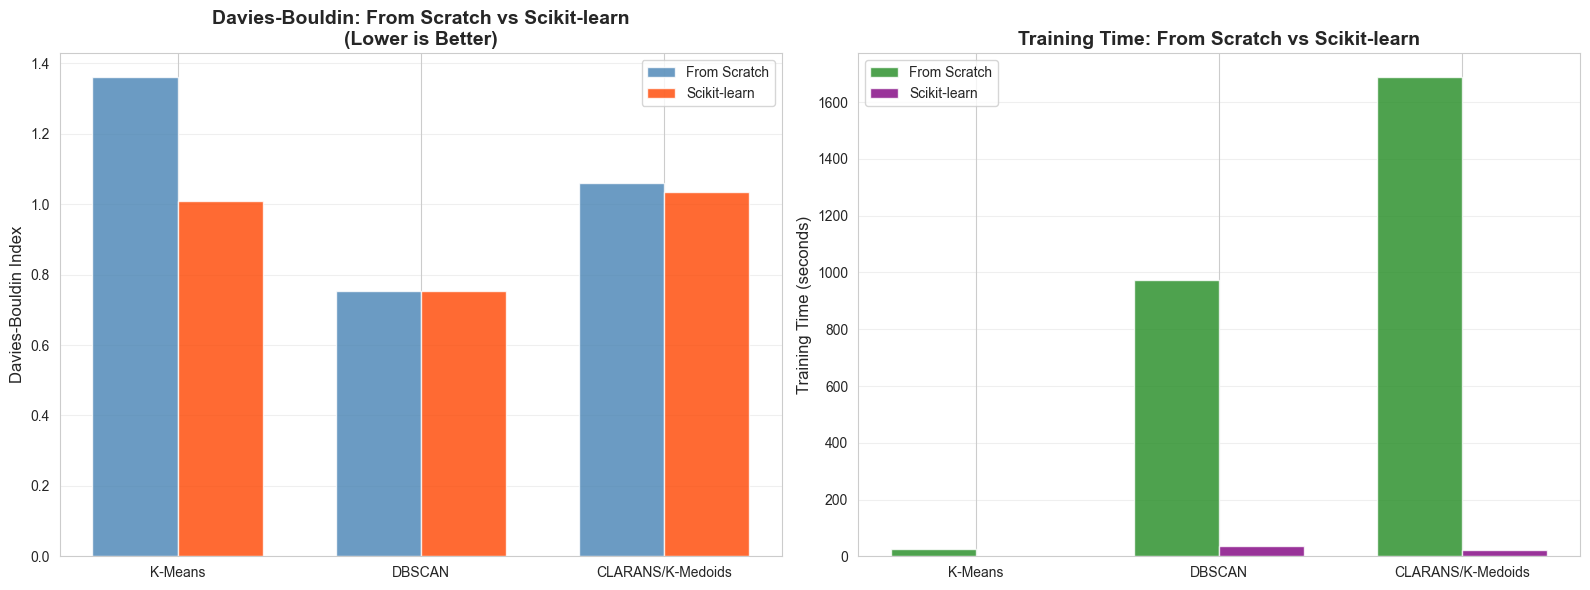


 Comparison complete


In [19]:
def compare_with_sklearn(X_scaled, labels_dict):
    """
    Compare from-scratch implementations with scikit-learn.
    """
    
    print("\n" + "="*70)
    print("COMPARISON WITH SCIKIT-LEARN")
    print("="*70)
    
    results = []
    
    # K-Means - Sklearn
    print("\n K-Means (Scikit-learn)...")
    start = time()
    sk_kmeans = SKKMeans(n_clusters=3, n_init=10, random_state=42)
    sk_kmeans_labels = sk_kmeans.fit_predict(X_scaled)
    train_time = time() - start
    
    sil = silhouette_score(X_scaled, sk_kmeans_labels)
    db = davies_bouldin_score(X_scaled, sk_kmeans_labels)
    
    results.append({
        'Model': 'K-Means (Sklearn)',
        'Silhouette': sil,
        'Davies-Bouldin': db,
        'Train Time': train_time
    })
    print(f"   Davies-Bouldin: {db:.4f}")
    
    # DBSCAN - Sklearn
    print("\n DBSCAN (Scikit-learn)...")
    start = time()
    sk_dbscan = SKDBSCAN(eps=0.10, min_samples=10, n_jobs=-1)
    sk_dbscan_labels = sk_dbscan.fit_predict(X_scaled)
    train_time = time() - start
    
    mask = sk_dbscan_labels != -1
    if mask.sum() > 0 and len(np.unique(sk_dbscan_labels[mask])) > 1:
        sil = silhouette_score(X_scaled[mask], sk_dbscan_labels[mask])
        db = davies_bouldin_score(X_scaled[mask], sk_dbscan_labels[mask])
    else:
        sil, db = np.nan, np.nan
    
    results.append({
        'Model': 'DBSCAN (Sklearn)',
        'Silhouette': sil,
        'Davies-Bouldin': db,
        'Train Time': train_time
    })
    

    db_display = f"{db:.4f}" if not np.isnan(db) else "N/A"
    print(f"   Davies-Bouldin: {db_display}")

    from sklearn.utils import resample
    if 10000 > 0:
        X_sample = resample(X_scaled, n_samples=10000, replace=False, random_state=42)
    else:
        X_sample = X_scaled
    
    # K-Medoids (CLARANS equivalent)
    print("\n K-Medoids (Scikit-learn)...")
    start = time()
    sk_kmedoids = KMedoids(n_clusters=3, method='pam', random_state=42)
    sk_kmedoids_labels = sk_kmedoids.fit_predict(X_sample)
    train_time = time() - start
    
    sil = silhouette_score(X_sample, sk_kmedoids_labels)
    db = davies_bouldin_score(X_sample, sk_kmedoids_labels)
    
    results.append({
        'Model': 'K-Medoids (Sklearn)',
        'Silhouette': sil,
        'Davies-Bouldin': db,
        'Train Time': train_time
    })
    print(f"   Davies-Bouldin: {db:.4f}")
    
    # Add from-scratch results
    results.append({
        'Model': 'K-Means (From Scratch)',
        'Silhouette': kmeans_metrics['silhouette'],
        'Davies-Bouldin': kmeans_metrics['davies_bouldin'],
        'Train Time': kmeans_metrics['train_time']
    })
    
    results.append({
        'Model': 'DBSCAN (From Scratch)',
        'Silhouette': dbscan_metrics.get('silhouette', np.nan),
        'Davies-Bouldin': dbscan_metrics.get('davies_bouldin', np.nan),
        'Train Time': dbscan_metrics['train_time']
    })
    
    results.append({
        'Model': 'CLARANS (From Scratch)',
        'Silhouette': clarans_metrics['silhouette'],
        'Davies-Bouldin': clarans_metrics['davies_bouldin'],
        'Train Time': clarans_metrics['train_time']
    })
    
    comparison_df = pd.DataFrame(results)
    
    print("\n Comparison Results:")
    print(comparison_df.to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    from_scratch = comparison_df[comparison_df['Model'].str.contains('From Scratch')]
    sklearn_models = comparison_df[~comparison_df['Model'].str.contains('From Scratch')]
    
    # Davies-Bouldin comparison
    x = np.arange(3)
    width = 0.35
    
    # Ensure we align correct pairs by sorting or explicit indexing if needed, 
    # but assuming order is preserved from append:
    axes[0].bar(x - width/2, from_scratch['Davies-Bouldin'].values, width,
               label='From Scratch', color='steelblue', alpha=0.8)
    axes[0].bar(x + width/2, sklearn_models['Davies-Bouldin'].values, width,
               label='Scikit-learn', color='orangered', alpha=0.8)
    
    axes[0].set_ylabel('Davies-Bouldin Index', fontsize=12)
    axes[0].set_title('Davies-Bouldin: From Scratch vs Scikit-learn\n(Lower is Better)',
                     fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(['K-Means', 'DBSCAN', 'CLARANS/K-Medoids'])
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Training time comparison
    axes[1].bar(x - width/2, from_scratch['Train Time'].values, width,
               label='From Scratch', color='forestgreen', alpha=0.8)
    axes[1].bar(x + width/2, sklearn_models['Train Time'].values, width,
               label='Scikit-learn', color='purple', alpha=0.8)
    
    axes[1].set_ylabel('Training Time (seconds)', fontsize=12)
    axes[1].set_title('Training Time: From Scratch vs Scikit-learn',
                     fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(['K-Means', 'DBSCAN', 'CLARANS/K-Medoids'])
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n Comparison complete")
    print("="*70)
    
    return comparison_df

# Compare with sklearn
sklearn_comparison = compare_with_sklearn(X_scaled, labels_dict)

## 9. Save Models and Results

In [20]:

def save_clustering_models(models_dict, scaler):
    """
    Save all trained clustering models.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary of models
    scaler : MinMaxScaler
        Fitted scaler
    """
    
    print("\n" + "="*70)
    print("SAVING MODELS")
    print("="*70)
    
    import os
    os.makedirs('../models/from_scratch/unsupervised', exist_ok=True)
    
    for model_name, model in models_dict.items():
        filepath = f'../models/from_scratch/unsupervised/{model_name}_model.pkl'
        
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)
        
        print(f" {model_name.upper()} saved: {filepath}")
    
    # Save scaler
    scaler_path = '../models/from_scratch/unsupervised/scaler.pkl'
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f" Scaler saved: {scaler_path}")
    
    print("="*70)

def save_clustering_results(comparison_df, sklearn_comparison, fire_risk_results, labels_dict, df):
    """
    Save all clustering results to CSV files.
    
    Parameters:
    -----------
    comparison_df : DataFrame
        Model comparison
    sklearn_comparison : DataFrame
        Sklearn comparison
    fire_risk_results : dict
        Fire risk analysis
    labels_dict : dict
        Cluster labels
    df : DataFrame
        Original dataframe
    """
    
    print("\n" + "="*70)
    print("SAVING RESULTS TO CSV")
    print("="*70)
    
    import os
    os.makedirs('../outputs/unsupervised_results', exist_ok=True)
    
    # Save comparison
    path1 = '../outputs/unsupervised_results/clustering_comparison.csv'
    comparison_df.to_csv(path1, index=False)
    print(f" Model comparison saved: {path1}")
    
    # Save sklearn comparison
    path2 = '../outputs/unsupervised_results/sklearn_comparison.csv'
    sklearn_comparison.to_csv(path2, index=False)
    print(f" Sklearn comparison saved: {path2}")
    
    # Save fire risk analysis
    for method_name, risk_df in fire_risk_results.items():
        path = f'../outputs/unsupervised_results/fire_risk_{method_name}.csv'
        risk_df.to_csv(path, index=False)
        print(f" Fire risk ({method_name}) saved: {path}")
    
    # Save labeled dataset
    df_labeled = df.copy()
    df_labeled['kmeans_cluster'] = labels_dict['kmeans']
    df_labeled['dbscan_cluster'] = labels_dict['dbscan']
    df_labeled['clarans_cluster'] = labels_dict['clarans']
    
    path3 = '../outputs/unsupervised_results/clustered_data.csv'
    df_labeled.to_csv(path3, index=False)
    print(f" Labeled dataset saved: {path3}")
    
    print("\n All results saved to: ../outputs/unsupervised_results/")
    print("="*70)

# Save models
save_clustering_models(models_dict, scaler)

# Save results
save_clustering_results(comparison_results, sklearn_comparison, 
                       fire_risk_results, labels_dict, df)



SAVING MODELS
 KMEANS saved: ../models/from_scratch/unsupervised/kmeans_model.pkl
 DBSCAN saved: ../models/from_scratch/unsupervised/dbscan_model.pkl
 CLARANS saved: ../models/from_scratch/unsupervised/clarans_model.pkl
 Scaler saved: ../models/from_scratch/unsupervised/scaler.pkl

SAVING RESULTS TO CSV
 Model comparison saved: ../outputs/unsupervised_results/clustering_comparison.csv
 Sklearn comparison saved: ../outputs/unsupervised_results/sklearn_comparison.csv
 Fire risk (kmeans) saved: ../outputs/unsupervised_results/fire_risk_kmeans.csv
 Fire risk (dbscan) saved: ../outputs/unsupervised_results/fire_risk_dbscan.csv
 Fire risk (clarans) saved: ../outputs/unsupervised_results/fire_risk_clarans.csv
 Labeled dataset saved: ../outputs/unsupervised_results/clustered_data.csv

 All results saved to: ../outputs/unsupervised_results/
